<a href="https://colab.research.google.com/github/graphlit/graphlit-evals/blob/main/tonic-validate/Tonic_Validate_OpenAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade tonic_validate

In [ ]:
!pip install --upgrade openai

In [ ]:
import os
from typing import Optional
from tonic_validate import ValidateScorer, Benchmark, BenchmarkItem, LLMResponse, BenchmarkItem, Run
from tonic_validate.metrics import AnswerSimilarityMetric
from concurrent.futures import ThreadPoolExecutor
import os
import time
from datetime import datetime
import json
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import userdata

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# configure shared, writable folder containing sample data
tonic_validate_directory = "/content/drive/MyDrive/Colab Notebooks/Tonic Validate"

Initialize OpenAI

In [ ]:
from openai import OpenAI

os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

client = OpenAI()

Load benchmark questions & answers

In [ ]:
with open(f"{tonic_validate_directory}/Sample Data/qa_pairs.json", "r") as f:
    qa_pairs = json.load(f)

# for testing
qa_pairs = qa_pairs

benchmark = Benchmark(
    questions=[x["question"] for x in qa_pairs],
    answers=[x["answer"] for x in qa_pairs]
)

def run_to_dataframe(run: Run) -> pd.DataFrame:
    return pd.DataFrame(
        {
            "reference_question": [x.reference_question for x in run.run_data],
            "reference_answer": [x.reference_answer for x in run.run_data],
            "llm_answer": [x.llm_answer for x in run.run_data],
            "llm_context": [json.dumps(x.llm_context) for x in run.run_data],
            "answer_similarity": [x.scores["answer_similarity"] for x in run.run_data]
        }
    )

Define OpenAI helper functions

In [ ]:
def upload_essays():
    file_ids = []

    directory = f"{tonic_validate_directory}/Sample Data/paul_graham_essays"

    start_time = time.time()

    vector_store = client.beta.vector_stores.create(
      name="OpenAI Rag Test"
    )

    file_paths = [os.path.join(directory, filename) for filename in os.listdir(directory) if os.path.isfile(os.path.join(directory, filename))]
    file_streams = [open(path, "rb") for path in file_paths]

    file_batch = client.beta.vector_stores.file_batches.upload_and_poll(
      vector_store_id=vector_store.id, files=file_streams
    )

    duration = time.time() - start_time

    current_time = datetime.now()
    formatted_time = current_time.strftime("%H:%M:%S")

    print(f"Uploading essays took {duration:.2f} seconds. Finished at {formatted_time} UTC.")

    return vector_store.id

def create_assistant(vector_store_id):
    return client.beta.assistants.create(
        name=f"OpenAI Rag Test Files",
        instructions=(
            "You are a chatbot that answers questions about Paul Graham's essays. "
            "Use your knowledge base to best respond to questions. "
            "NO MATTER WHAT, DO NOT PULL INFORMATION FROM EXTERNAL KNOWLEDGE. ONLY USE YOUR OWN KNOWLEDGE BASE."
        ),
        model="gpt-4-turbo",
        tools=[{"type": "file_search"}],
        tool_resources={
          "file_search": {
            "vector_store_ids": [vector_store_id]
          }
        }
    )

# WARNING
# this deletes all vector stores associated with your openai api key.
def cleanup_vector_stores():
    for v in client.beta.vector_stores.list():
        client.beta.vector_stores.delete(v.id)

        print(f'Deleted vector store [{v.id}].')
        time.sleep(5)

def cleanup_files():
    for f in client.files.list():
        client.files.delete(f.id)

        print(f'Deleted file [{f.id}].')
        time.sleep(1)

Define OpenAI RAG function

In [ ]:
def get_openai_rag_response(benchmarkItem: BenchmarkItem, assistant):
    prompt = benchmarkItem.question
    thread = client.beta.threads.create(
        messages=[
            {
                "role": "user",
                "content": prompt
            }
        ]
    )
    run = client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=assistant.id,
    )
    max_retries = 15
    base = 0.1
    num_retries = 0
    try:
        while max_retries > 0:
            if max_retries == 0:
                client.beta.threads.delete(thread.id)
                raise Exception("Max tries exceeded")
            messages = client.beta.threads.messages.list(
                thread_id=thread.id,
            )
            if len(messages.data)>0:
                message = messages.data[0]

                if len(message.content)>0:
                    content = message.content[0]

                    response_message = content.text.value
                    if response_message != prompt and response_message.strip():
                        client.beta.threads.delete(thread.id)
                        return response_message
            time.sleep(base * (2 ** num_retries))
            num_retries += 1
            max_retries -= 1
    except Exception as e:
        print(e)
        client.beta.threads.delete(thread.id)
        raise e

Initialize OpenAI test

In [ ]:
cleanup_vector_stores()
cleanup_files()

assistant = None

vector_store_id = upload_essays()

if vector_store_id is not None:
    print(f'Essays ingested into vector store [{vector_store_id}].')

    assistant = create_assistant(vector_store_id)

Validate OpenAI response

In [ ]:
benchmark_item = BenchmarkItem(
    question="What key components are necessary to create a technology hub according to Paul Graham?",
    answer=""
)

print(get_openai_rag_response(benchmark_item, assistant))

Perform OpenAI test and score run

In [ ]:
import asyncio

async def run_test():
    with ThreadPoolExecutor() as executor:
        tasks = []
        for item in benchmark.items:
            task = asyncio.get_event_loop().run_in_executor(executor, get_openai_rag_response, item, assistant)
            tasks.append(task)

        return await asyncio.gather(*tasks)

raw_openai_responses = await run_test()

print(raw_openai_responses)

In [80]:
openai_responses = [
    LLMResponse(
        llm_answer=r if r is not None else "", llm_context_list=[], benchmark_item=bi
    ) for r, bi in zip(raw_openai_responses, benchmark.items)
]

In [81]:
scorer = ValidateScorer(model_evaluator="gpt-4-turbo", metrics=[AnswerSimilarityMetric()])
openai_run = scorer.score_run(openai_responses, parallelism=5)

Scoring responses:   4%|▎         | 2/55 [00:00<00:15,  3.45it/s]INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Scoring responses:   9%|▉         | 5/55 [00:01<00:09,  5.41it/s]INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Scoring responses:  15%|█▍        | 8/55 [00:01<00:08,  5.25it/s]INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Scoring responses:  20%|██        | 11/55 [00:01<00:05,  8.56it/s]INFO:httpx:

In [82]:
openai_run_df = run_to_dataframe(openai_run)
openai_run_df.to_csv(f"{tonic_validate_directory}/openai_run.csv", index=False)

Visualize OpenAI test

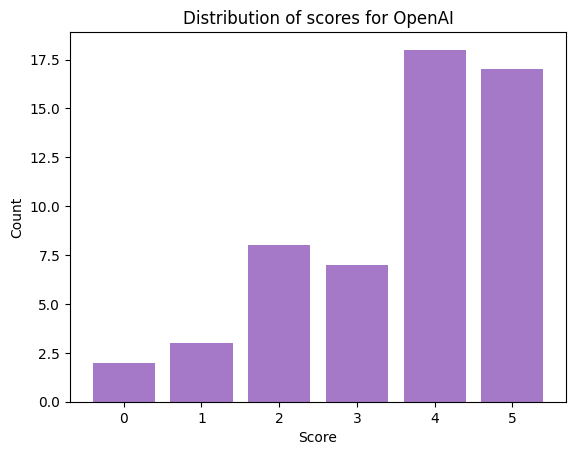

In [83]:
openai_answer_similarity_scores = pd.Series([x.scores["answer_similarity"] for x in openai_run.run_data])
category_counts = openai_answer_similarity_scores.value_counts()
plt.bar(category_counts.index, category_counts.values)

plt.title('Distribution of scores for OpenAI')
plt.xlabel('Score')
plt.ylabel('Count')

plt.bar(category_counts.index, category_counts.values, color='#A679C8')

# Remove all scores except whole numbers
plt.xticks(range(0, 6, 1))

plt.show()